## 1. Importing the libraries and process dataset

For MacOS, ensure that this is installed,

```
brew install libomp
brew install graphviz
```

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv('Social_Network_Ads.csv')
x = dataset.iloc[:, 0].values.reshape(-1, 1)
y = dataset.iloc[:, 1].values.reshape(-1, 1)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Standardize data
pt = PowerTransformer()
x_train = pt.fit_transform(x_train)
x_test = pt.transform(x_test)

## 2a. Train LinearRegression model

In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

## 2b. Display details

CV Score (mean):  -0.0245228178374017
CV Score (std):  0.07594377880495487
RMSE:  31864.651938177063


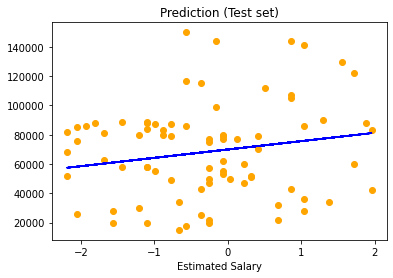

,x-value,y-value,y-predict-value,epsilon
70,[-0.5649169005378976],[150000],[66705.4946298199],[83294.5053701801]
7,[-0.15985649087865966],[144000],[69016.20612859525],[74983.79387140475]
21,[0.8669982269154786],[144000],[74874.01140256599],[69125.98859743401]
25,[1.0424179199966133],[141000],[75874.71226655619],[65125.28773344381]
73,[0.6884341201764491],[22000],[73855.37288625793],[51855.37288625793]
18,[1.551509810348311],[130000],[78778.88274808653],[51221.11725191347]
6,[-0.6693997086130442],[15000],[66109.46100054796],[51109.46100054796]
...,...,...,...,...
67,[-1.1020204867416494],[58000],[63641.5283594096],[5641.528359409604]
45,[-1.1020204867416494],[58000],[63641.5283594096],[5641.528359409604]


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML

def display_details():
    accuracies = cross_val_score(estimator=model, X=x_train, y=y_train, cv=10)
    y_pred = model.predict(x_test)

    print('CV Score (mean): ', accuracies.mean())
    print('CV Score (std): ', accuracies.std())
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

    plt.scatter(x_test, y_test, color='orange')
    plt.plot(x_test, model.predict(x_test), color='blue')
    plt.title('Prediction (Test set)')
    plt.xlabel('Age')
    plt.xlabel('Estimated Salary')
    plt.show()
    
    df = pd.DataFrame(list(zip(x_test, y_test, model.predict(x_test))), columns=['x-value', 'y-value', 'y-predict-value'])
    df['epsilon'] = np.abs(df['y-value'] - df['y-predict-value'])
    df = df.sort_values(['epsilon'], ascending=False)
    display(HTML(df.to_html(max_rows=15)))
    
display_details()

## 3a. Training the XGBoost Regressor

<img src="https://docs.aws.amazon.com/sagemaker/latest/dg/images/xgboost_illustration.png" width="650" height="auto" />

(Source: [amazon.com, n.d.](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html))

Credits: [@nikki2398](https://www.geeksforgeeks.org/xgboost-for-regression)

The key metrics for XGBoost models,

- **RMSE**: It is the square root of mean squared error (MSE).
- **MAE**: It is an absolute sum of actual and predicted differences, but it lacks mathematically, that’s why it is rarely used, as compared to other metrics.


The objective function contains loss function and a regularization term and tells about the difference between actual values and predicted values.

The most common loss functions in XGBoost for regression problems is `reg:linear`, and that for binary classification is `reg:logistics`.

Steps are,

1. Calculate the similarity scores, it helps in growing the tree.

   ```
   Similarity Score = (Sum of residuals)^2 / Number of residuals + lambda
   ```

2. Calculate the gain to determine how to split the data.

   ```
   Gain = Left tree (similarity score) + Right (similarity score) - Root (similarity score)
   ```

3. Prune the tree by calculating the difference between Gain and gamma (user-defined tree-complexity parameter) 

   ```
   Gain - gamma
   ```
  
   If the result is a positive number then do not prune and if the result is negative, then prune and again subtract gamma from the next Gain value way up the tree.

4. Calculate output value for the remaining leaves

   ```
   Output value = Sum of residuals / Number of residuals + lambda
   ```
   
   If the value of lambda is greater than `0`, it results in more pruning by shrinking the similarity scores and it results in smaller output values for the leaves.
   
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200726142952/g1.PNG" width="500" height="auto" />

(Source: [@nikki2398, 2020](https://www.geeksforgeeks.org/xgboost-for-regression))

For classification and regression, XGBoost starts with an initial prediction usually `0.5`, as shown in the below diagram.

To find how good the prediction is, calculate the Loss function, by using the formula,

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200726143401/gg2.PNG" width="500" height="auto" />

(Source: [@nikki2398, 2020](https://www.geeksforgeeks.org/xgboost-for-regression))

In [4]:
from xgboost import XGBRegressor
import xgboost

xgboost.set_config(verbosity=0)

model = XGBRegressor(objective='reg:linear', booster='gblinear', n_estimators=250, max_depth=250, learning_rate=1.85, reg_lambda=25)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=1.85, max_delta_step=None, max_depth=250,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=4, num_parallel_tree=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=25,
             scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

## 3b. Display details

CV Score (mean):  -0.045069881863891395
CV Score (std):  0.061818319799702454
RMSE:  32109.950684134117


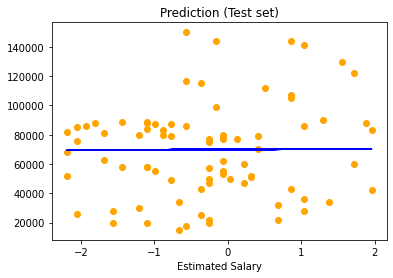

,x-value,y-value,y-predict-value,epsilon
70,[-0.5649169005378976],[150000],69804.164062,[80195.8359375]
7,[-0.15985649087865966],[144000],69893.039062,[74106.9609375]
21,[0.8669982269154786],[144000],70118.335938,[73881.6640625]
25,[1.0424179199966133],[141000],70156.828125,[70843.171875]
18,[1.551509810348311],[130000],70268.523438,[59731.4765625]
6,[-0.6693997086130442],[15000],69781.234375,[54781.234375]
60,[-0.5649169005378976],[18000],69804.164062,[51804.1640625]
...,...,...,...,...
16,[-0.06155679245322992],[77000],69914.601562,[7085.3984375]
13,[0.1317926694510487],[77000],69957.023438,[7042.9765625]


In [5]:
display_details()